# TriageAssist: audit the dataset & models with Microsoft Fairlearn

In [1]:
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

## Load Dataset

In [3]:
# load data
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

### 1 = male, 0 = female
print(df.isnull().sum())
print(df.head())

df['Sex'] = df.Sex.map({'F': 'female', 'M': 'male'})

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4    

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,male,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,female,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,male,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,female,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,male,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Dataset Imbalance

In [6]:
categorical_features = ["Sex"]

for col_name in categorical_features:
    df[col_name] = df[col_name].astype("category")

Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]))

In [7]:
# gender
A.value_counts(normalize=True)

Sex
male      0.78976
female    0.21024
Name: proportion, dtype: float64

In [9]:
B = df.loc[:,'Age']
B.value_counts()

Age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: count, dtype: int64

In [12]:
# target
Y.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

### Add synthetic noise that is related to the outcome and sex

In [21]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

df['Sex'] = df.Sex.map({'F': 2, 'M': 1})
Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]))
X.loc[:, "Fatigue"] = np.random.normal(loc=2 * Y, scale=A)

In [22]:
# gender
A.value_counts(normalize=True)

Sex
1    0.78976
2    0.21024
Name: proportion, dtype: float64

In [23]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Fatigue
0,40,140,289,0,172,0.0,False,True,False,False,False,True,False,True,False,False,False,True,0.405121
1,49,160,180,0,156,1.0,False,False,True,False,False,True,False,True,False,False,True,False,2.861835
2,37,130,283,0,98,0.0,False,True,False,False,False,False,True,True,False,False,False,True,1.242878
3,48,138,214,0,108,1.5,True,False,False,False,False,True,False,False,True,False,True,False,0.488885
4,54,150,195,0,122,0.0,False,False,True,False,False,True,False,True,False,False,False,True,0.393633


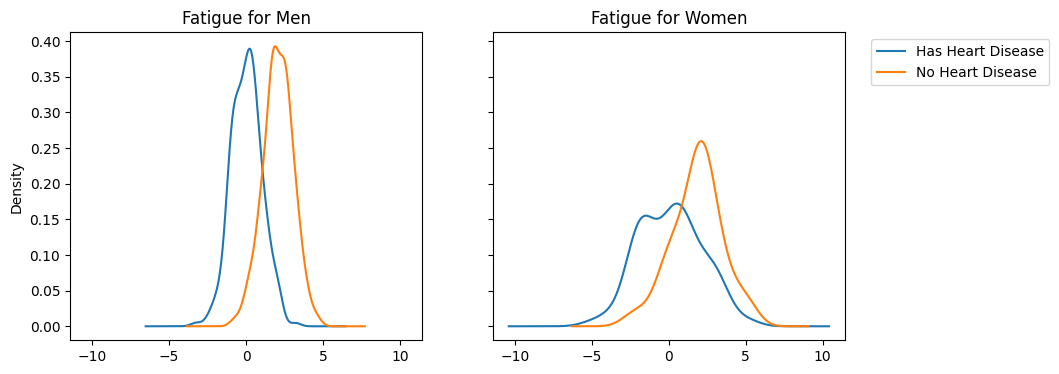

In [25]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Fatigue"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Has Heart Disease", ax=ax_1, title="Fatigue for Men"
)
X["Fatigue"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="No Heart Disease", ax=ax_1
)
X["Fatigue"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Has Heart Disease",
    ax=ax_2,
    legend=True,
    title="Fatigue for Women",
)
X["Fatigue"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="No Heart Disease", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

### Training an initial model

In [43]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [27]:
A_str = A.map({1: "male", 2: "female"})
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [29]:
import lightgbm as lgb

lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 330, number of negative: 330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234))])

In [30]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

In [31]:
roc_auc_score(y_test, Y_pred_proba)

0.9580992509363296

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

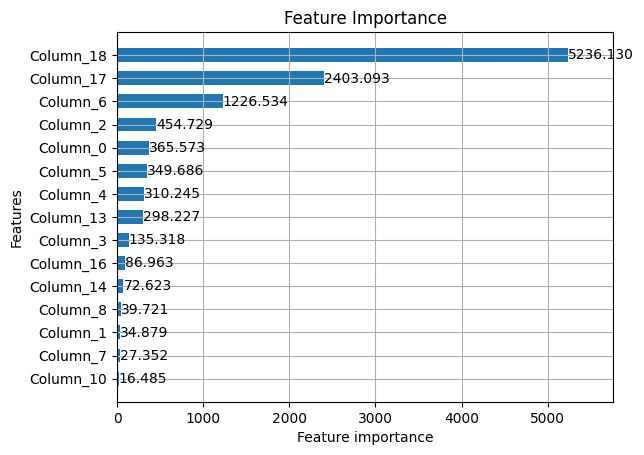

In [32]:
lgb.plot_importance(
    estimator.named_steps["classifier"],
    height=0.6,
    title="Feature Importance",
    importance_type="gain",
    max_num_features=15,
)

## Classification

In [29]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

columns = [
    "Sex",
    "ChestPainType",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope"
]
df = pd.get_dummies(df, prefix = columns  , columns = columns , dtype = float)

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [77]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

df['Sex'] = df.Sex.map({'F': 2, 'M': 1})
Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease"]), dtype = float)

A_str = A.map({1: "male", 2: "female"})
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.2, stratify=Y
)
X.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,2,160,180,0,156,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,2,138,214,0,108,1.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,1,150,195,0,122,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [79]:
print(len(X.columns), "features are used for training.")

19 features are used for training.


In [36]:
# normalization
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_val = (X_val - np.mean(X_val))/np.std(X_val)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn import tree

### Decision Tree

In [80]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

Training accuracy: 100.00% | Test accuracy: 79.89%
Training accuracy: 94.14% | Test accuracy: 84.24%
Training accuracy: 89.10% | Test accuracy: 82.61%
Training accuracy: 88.15% | Test accuracy: 83.15%
Training accuracy: 87.19% | Test accuracy: 80.43%
Training accuracy: 84.20% | Test accuracy: 81.52%
Training accuracy: 84.06% | Test accuracy: 81.52%
Training accuracy: 81.06% | Test accuracy: 82.61%


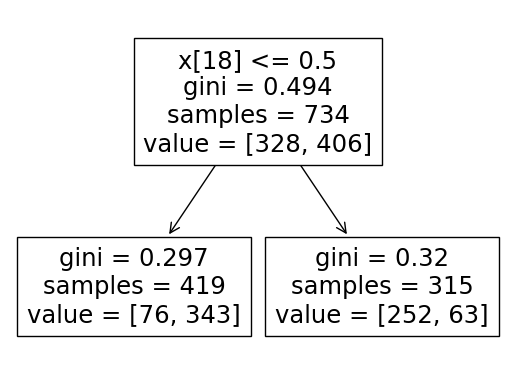

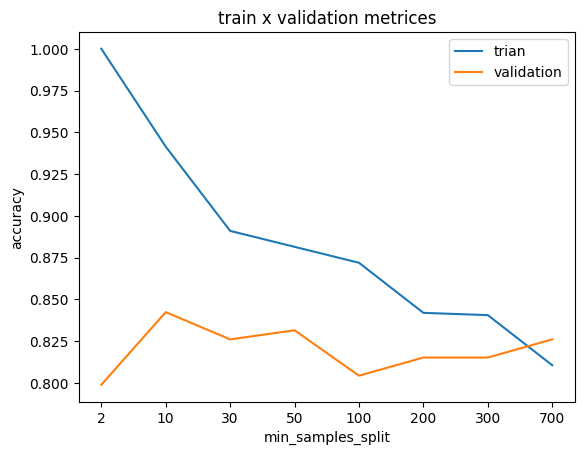

In [81]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples).fit(X_train, y_train)
    tree.plot_tree(model)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_test)
    print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_test)*100))
    accuracy_list_train.append(accuracy_score(train_pred, y_train))
    accuracy_list_val.append(accuracy_score(val_pred, y_test))
plt.show()  
    
plt.title("train x validation metrices")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(["trian", "validation"])

Training accuracy: 81.06% | Test accuracy: 82.61%
Training accuracy: 84.06% | Test accuracy: 81.52%
Training accuracy: 86.38% | Test accuracy: 82.07%
Training accuracy: 88.56% | Test accuracy: 83.15%
Training accuracy: 97.00% | Test accuracy: 84.78%
Training accuracy: 100.00% | Test accuracy: 80.98%
Training accuracy: 100.00% | Test accuracy: 80.98%
Training accuracy: 100.00% | Test accuracy: 80.98%
Training accuracy: 100.00% | Test accuracy: 80.98%


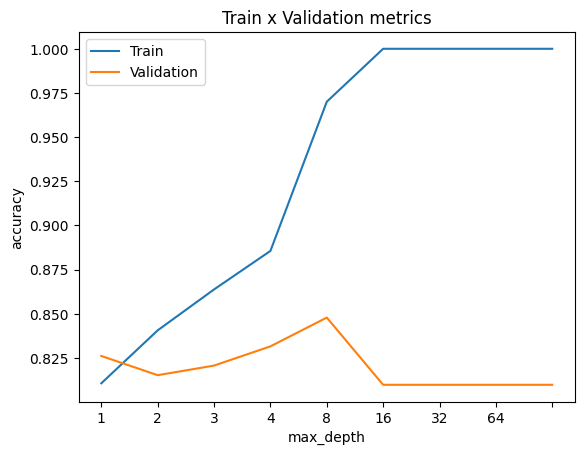

In [82]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 234).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))
    

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 88.15% | Validation accuracy: 83.15%


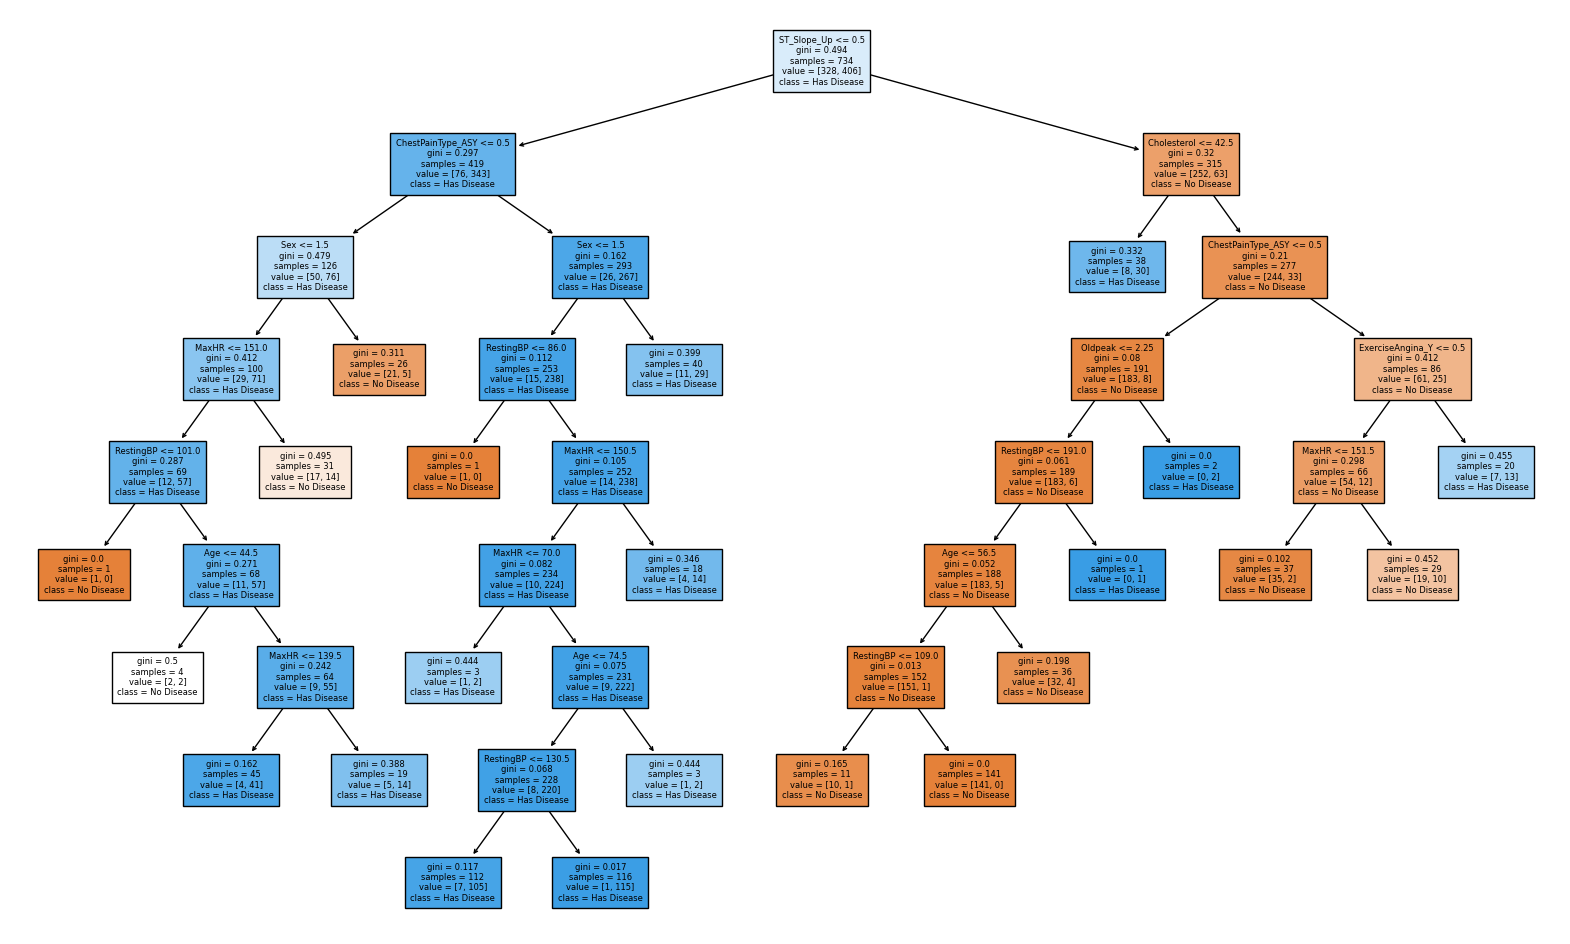

In [85]:
feature_names = list(X.columns)
fig, ax = plt.subplots(1,1,figsize=(20,12))
model = DecisionTreeClassifier(min_samples_split = 50, max_depth=8, random_state=21).fit(X_train, y_train)
train_pred = model.predict(X_train)
val_pred = model.predict(X_test)
print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_test)*100))

tree.plot_tree(model, feature_names = feature_names, ax=ax, fontsize=6, class_names=['No Disease', 'Has Disease'], filled=True)
plt.show()

### Random Forest

In [ ]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

Training accuracy: 100.00% | Test accuracy: 86.41%
Training accuracy: 93.60% | Test accuracy: 86.96%
Training accuracy: 89.51% | Test accuracy: 85.33%
Training accuracy: 88.69% | Test accuracy: 86.96%
Training accuracy: 87.47% | Test accuracy: 86.41%
Training accuracy: 86.65% | Test accuracy: 85.87%
Training accuracy: 83.38% | Test accuracy: 85.33%
Training accuracy: 55.31% | Test accuracy: 55.43%


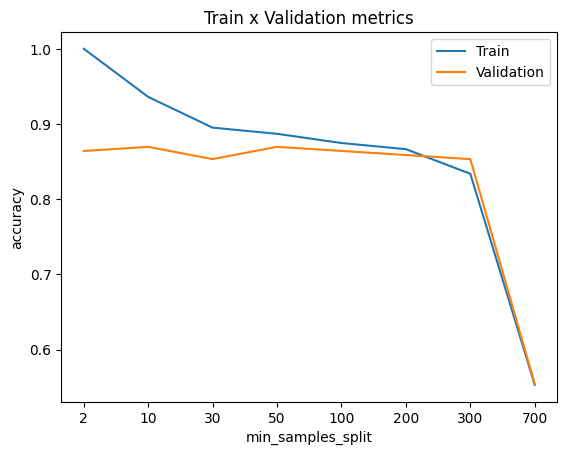

In [87]:
n_estimators_list = [10,50,100,500]
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 234).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 83.92% | Test accuracy: 86.96%
Training accuracy: 85.97% | Test accuracy: 84.78%
Training accuracy: 87.19% | Test accuracy: 86.41%
Training accuracy: 88.83% | Test accuracy: 85.87%
Training accuracy: 96.46% | Test accuracy: 86.96%
Training accuracy: 100.00% | Test accuracy: 86.41%
Training accuracy: 100.00% | Test accuracy: 86.96%
Training accuracy: 100.00% | Test accuracy: 86.96%
Training accuracy: 100.00% | Test accuracy: 86.96%


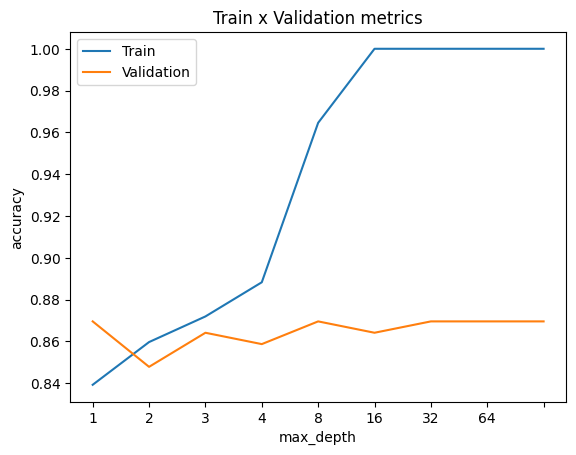

In [89]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 55).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 98.91% | Test accuracy: 85.87%
Training accuracy: 100.00% | Test accuracy: 88.04%
Training accuracy: 100.00% | Test accuracy: 86.96%
Training accuracy: 100.00% | Test accuracy: 86.41%


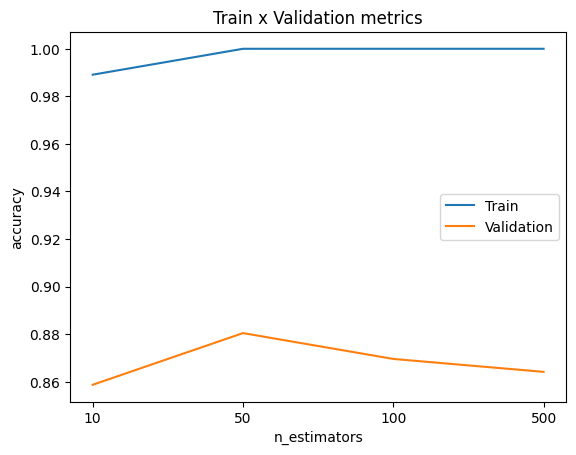

In [90]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 21).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

In [92]:
random_forest_model = RandomForestClassifier(max_depth = 8, 
                                            min_samples_split = 100,
                                            n_estimators = 10,
                                            random_state = 21).fit(X_train, y_train)

train_pred = random_forest_model.predict(X_train)
val_pred = random_forest_model.predict(X_test)
print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_test)*100))
    

Training accuracy: 87.06% | Test accuracy: 86.41%


Training accuracy: 87.06% | Test accuracy: 86.41%


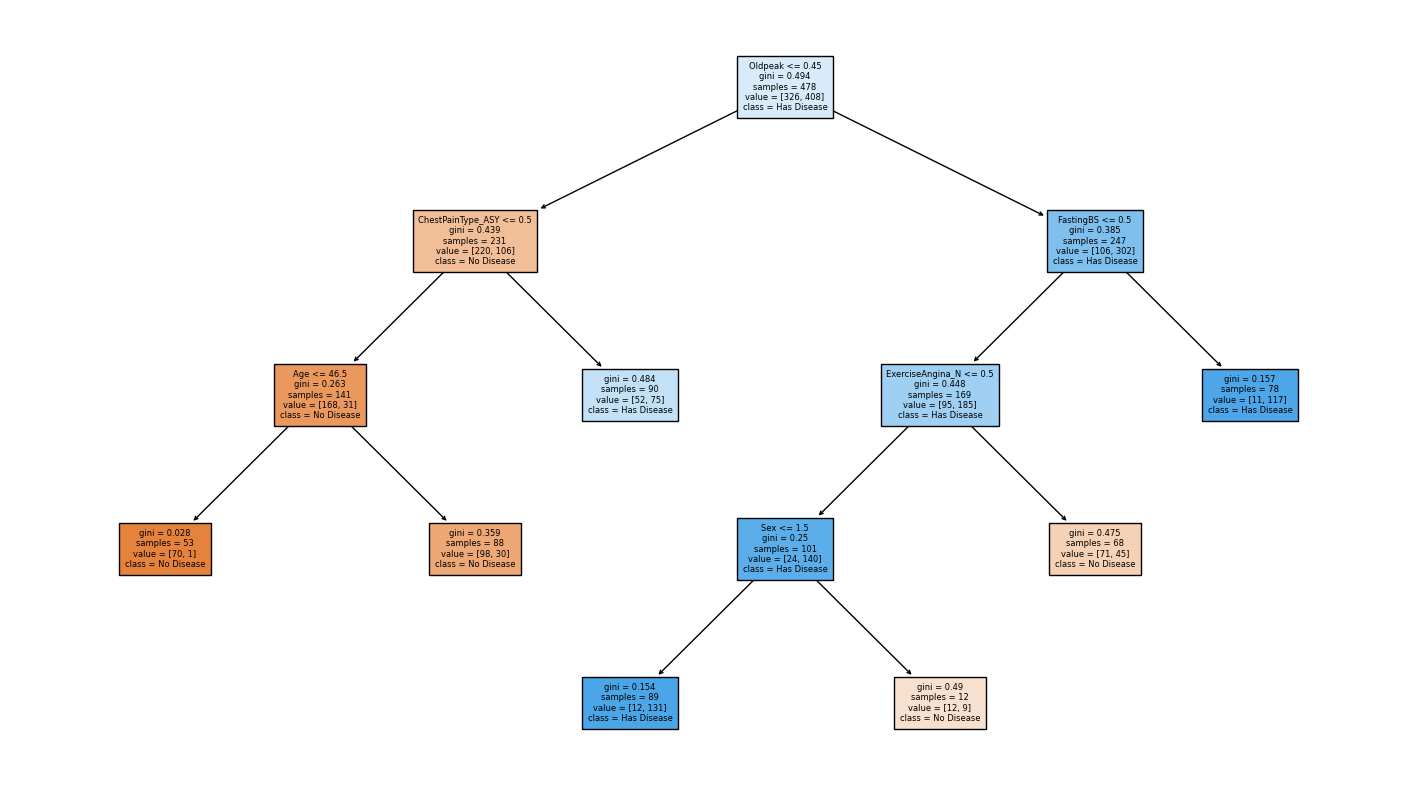

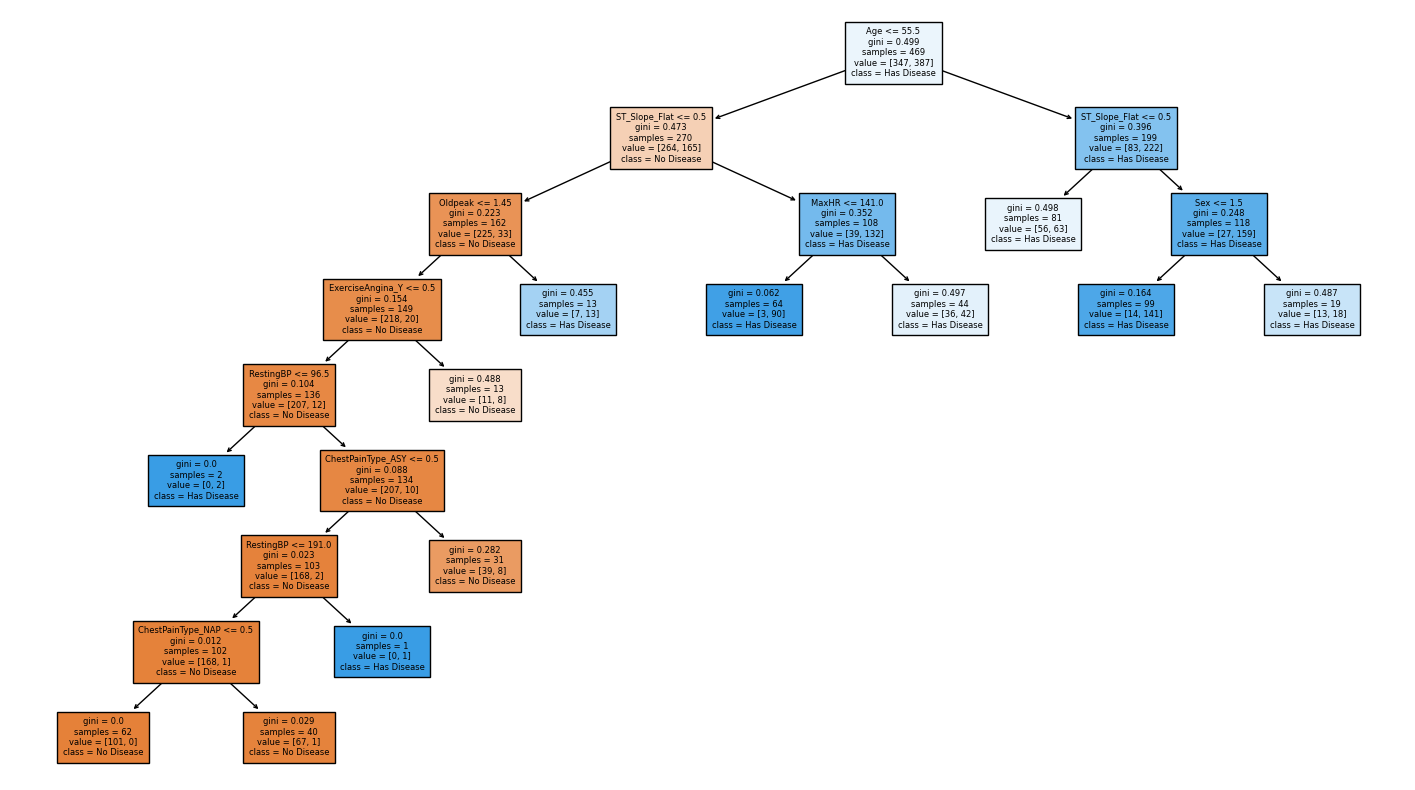

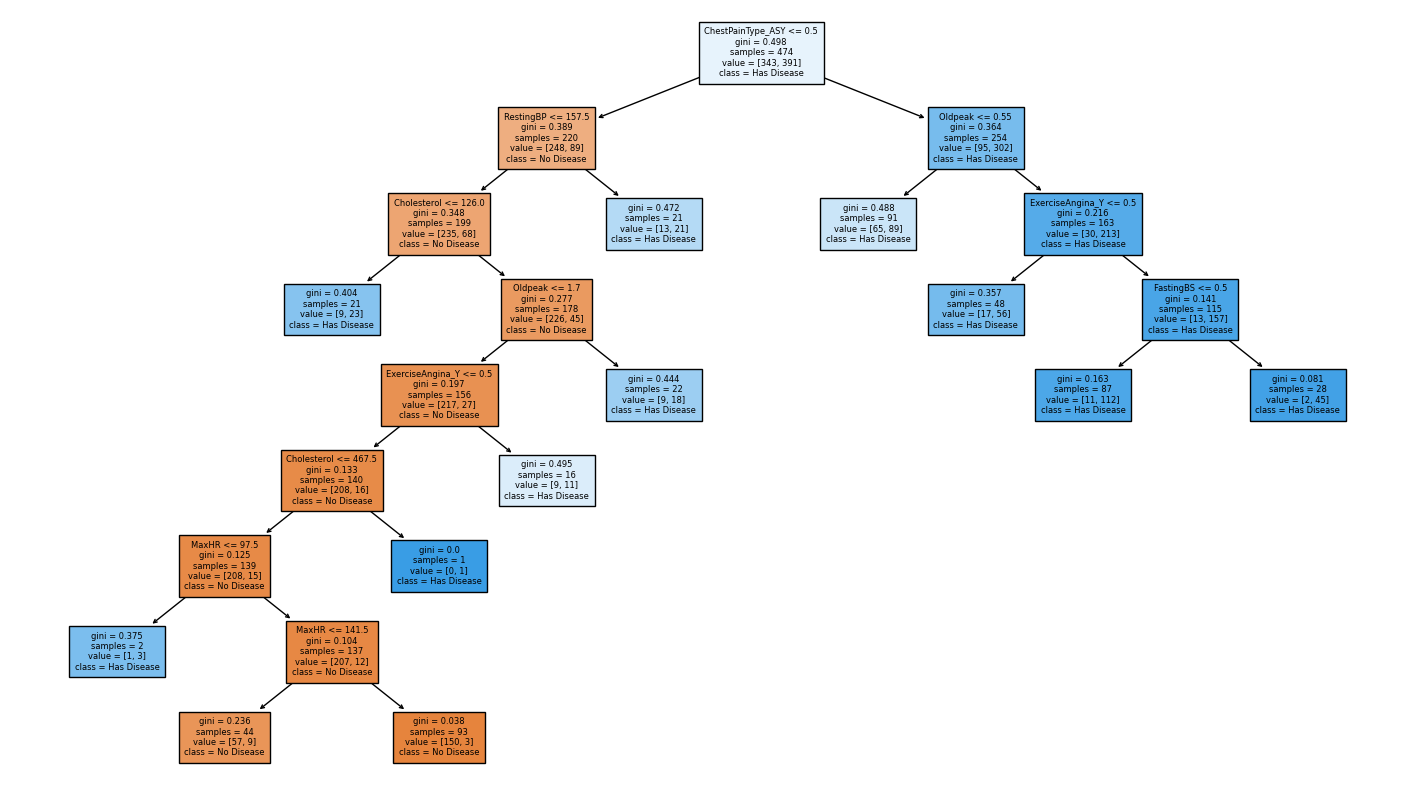

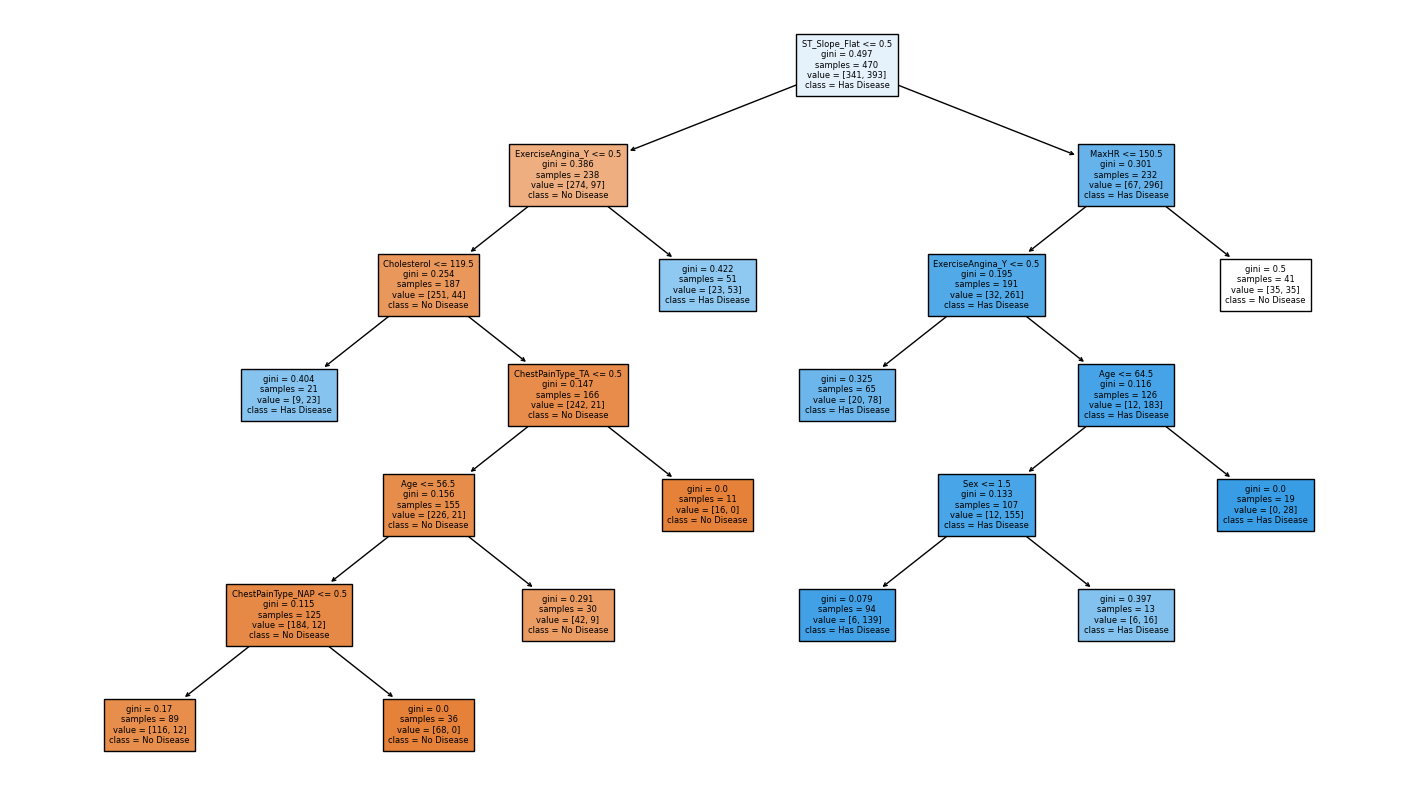

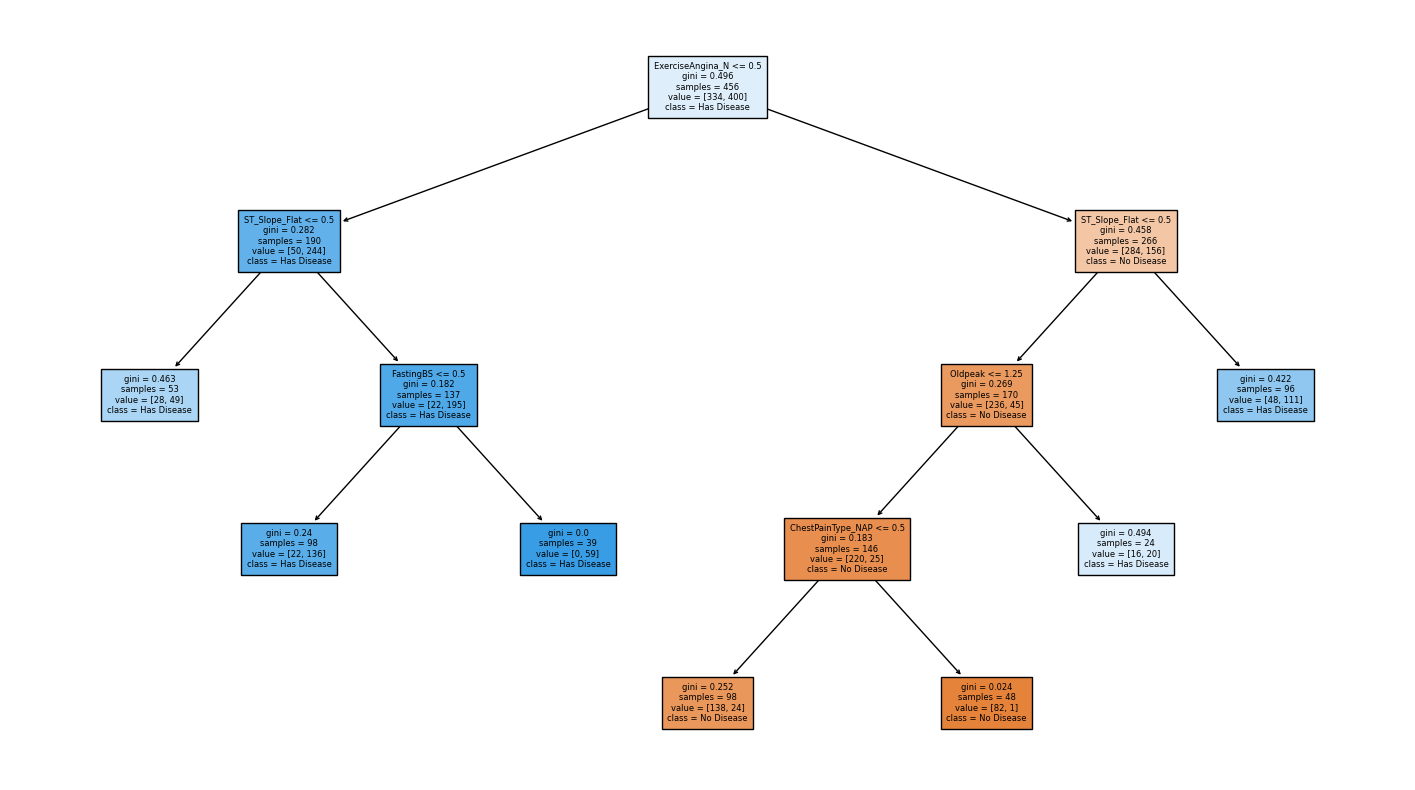

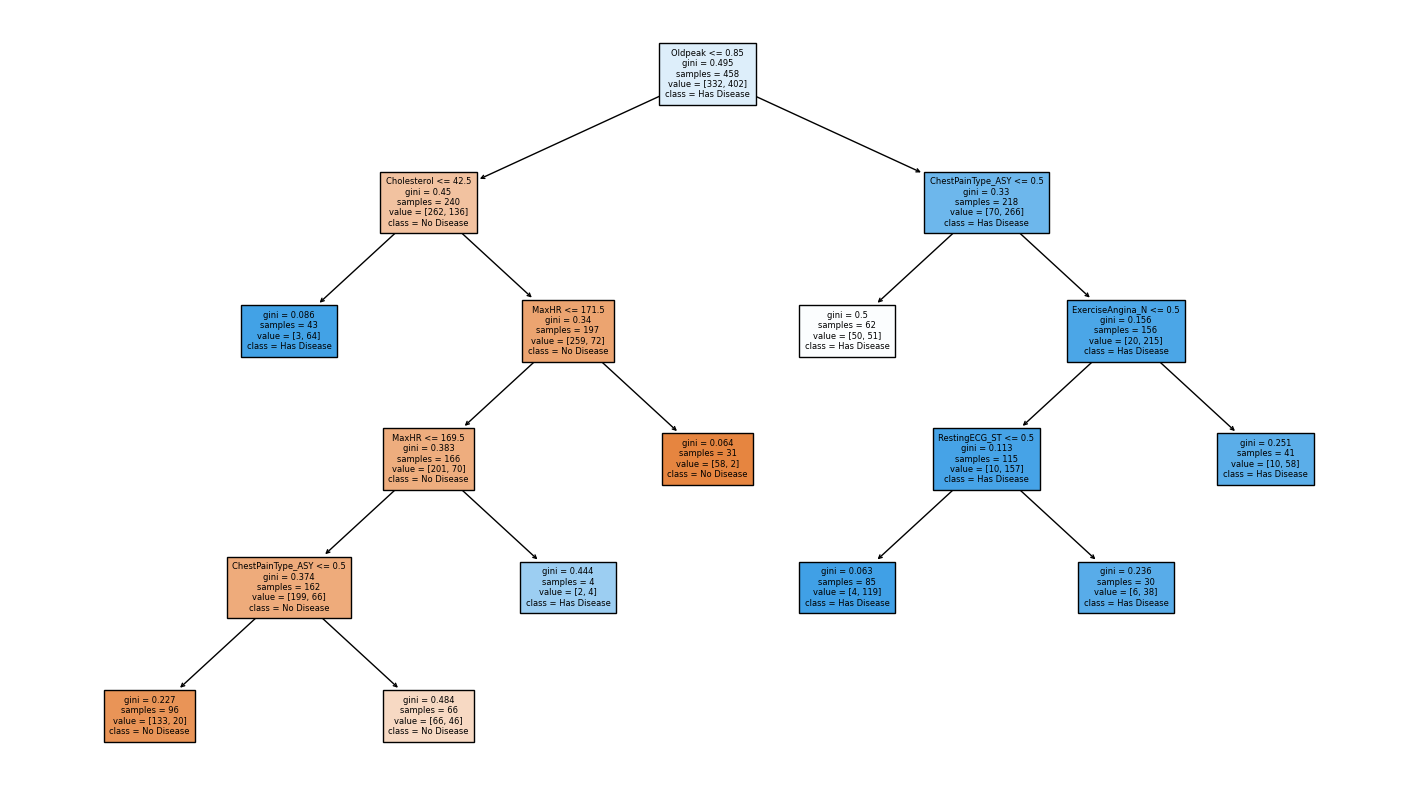

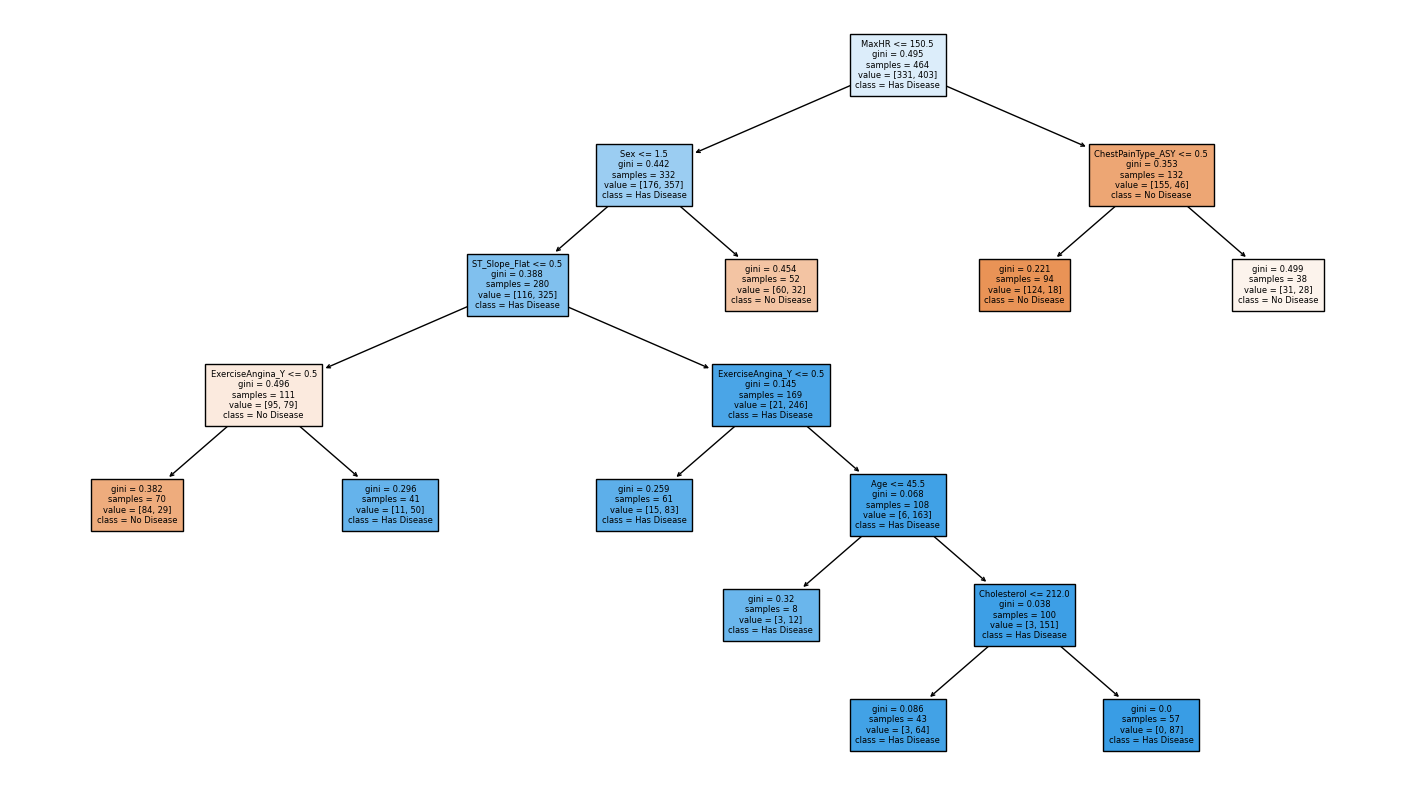

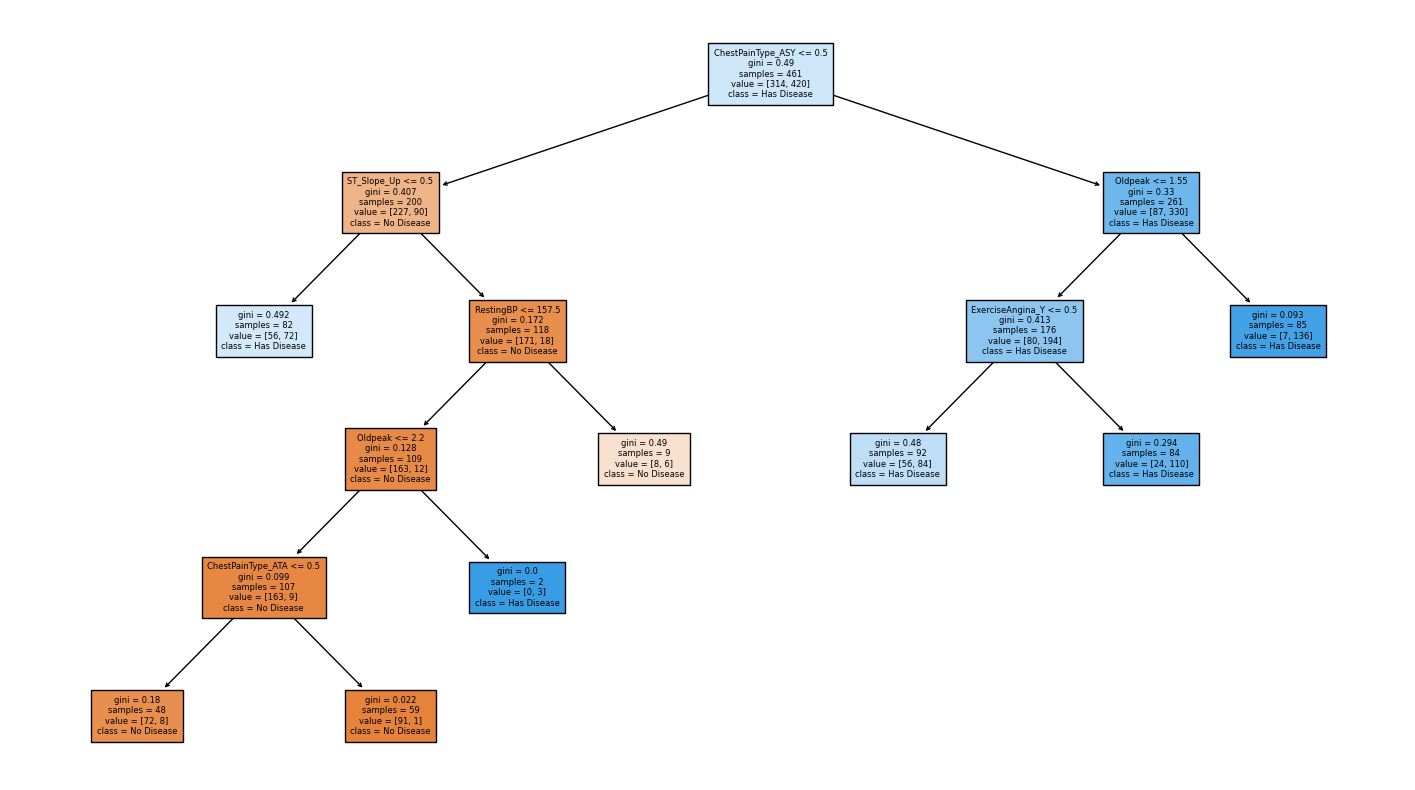

In [95]:
feature_names = list(X.columns)
# fig, ax = plt.subplots(1,1,figsize=(18,10))
random_forest_model = RandomForestClassifier(max_depth = 8, 
                                            min_samples_split = 100,
                                            n_estimators = 10,
                                            random_state = 21).fit(X_train, y_train)

train_pred = random_forest_model.predict(X_train)
val_pred = random_forest_model.predict(X_test)
print("Training accuracy: {:.2f}% | Test accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_test)*100)) 

for i in range(8):
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    tree.plot_tree(random_forest_model.estimators_[i], feature_names = feature_names, ax=ax, fontsize=6, class_names=['No Disease', 'Has Disease'], filled=True)
    filename = 'figures/random_forest/Fig_random_forest_tree_'+str(i+1)+'.png'
    plt.show()

### Logisitic Regression

## Fairness Metrics

### Load the dataset

In [98]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

df['Sex'] = df.Sex.map({'F': 2, 'M': 1})
Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]), dtype = float)

A_str = A.map({1: "male", 2: "female"})
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

### Train the model

Training accuracy: 85.91% | Testaccuracy: 83.23%


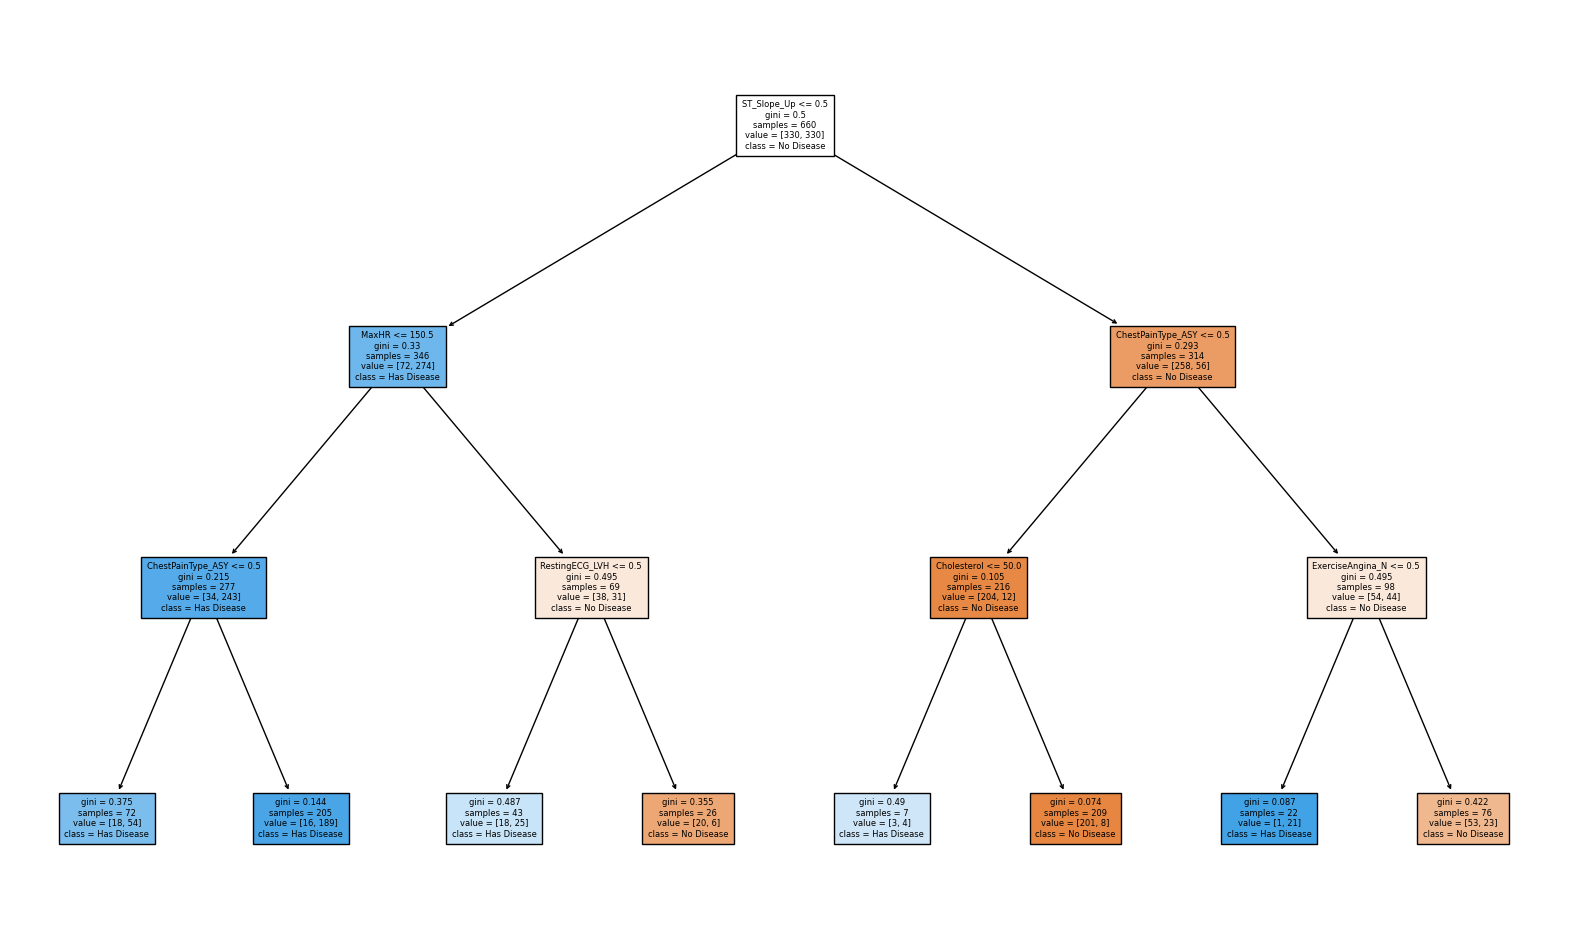

In [99]:
# training the decision tree

feature_names = list(X.columns)
fig, ax = plt.subplots(1,1,figsize=(20,12))
model = DecisionTreeClassifier(min_samples_split = 50, max_depth=3, random_state=21).fit(X_train, y_train)
train_pred = model.predict(X_train)
val_pred = model.predict(X_test)
print("Training accuracy: {:.2f}% | Testaccuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_test)*100))
    
tree.plot_tree(model, feature_names = feature_names, ax=ax, fontsize=6, class_names=['No Disease', 'Has Disease'], filled=True)
plt.show()

### Compute the metrics

In [100]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}


In [101]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

Y_pred = model.predict(X_test)
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]
metricframe_unmitigated.difference()[metrics_to_report]
metricframe_unmitigated.overall[metrics_to_report]


balanced_accuracy      0.823112
false_positive_rate    0.263889
false_negative_rate    0.089888
dtype: float64

In [102]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

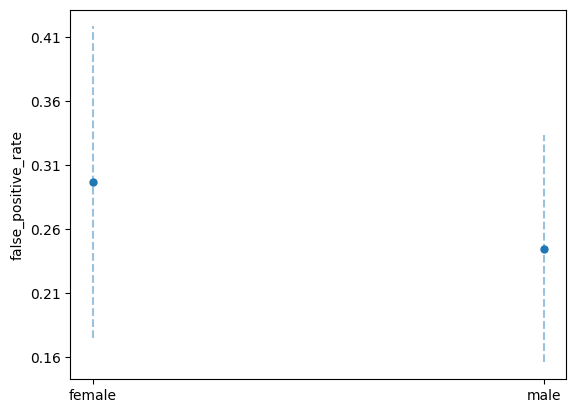

In [103]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

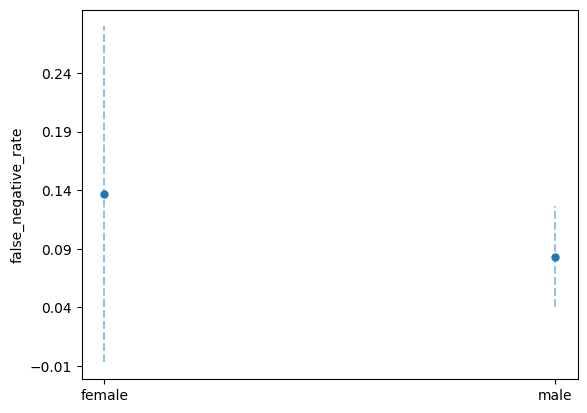

In [104]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

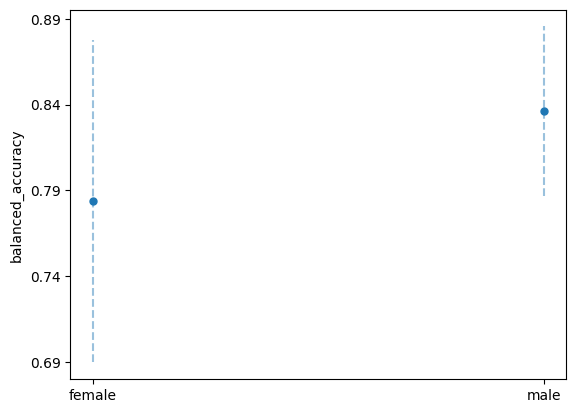

In [105]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "balanced_accuracy", "balanced_acc_error"
)

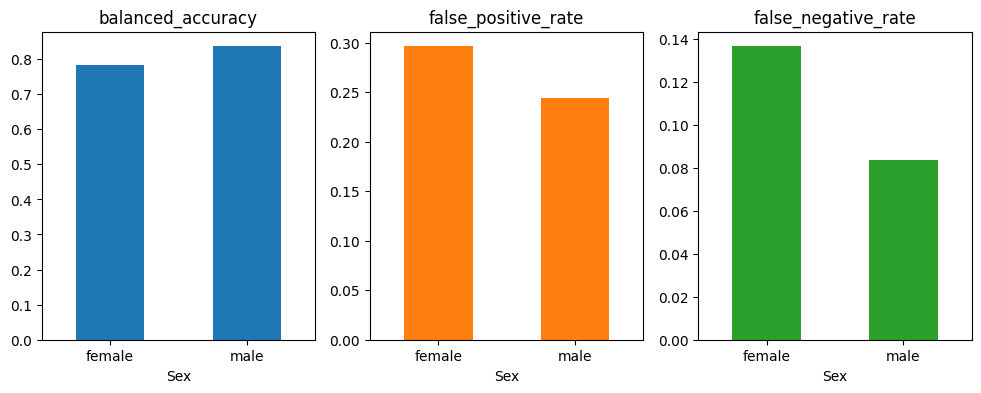

In [106]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)
plt.show()

In [107]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)
print(balanced_accuracy_unmitigated)
print(equalized_odds_unmitigated)

0.8231117353308365
0.05303030303030298


## Mitigating Unfairness in ML models

In [108]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [109]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)
postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)
postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

### Fairness assessment of postprocessing model

In [110]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )


In [111]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy      0.002655
false_positive_rate    0.074074
false_negative_rate    0.068765
dtype: float64

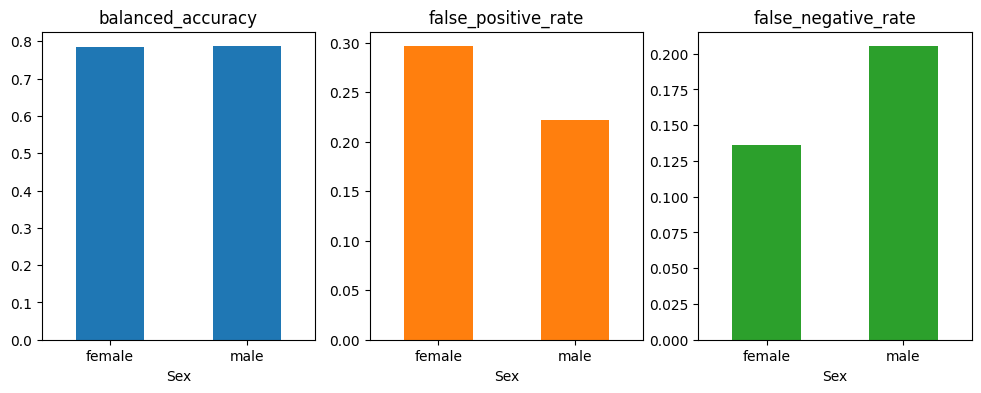

In [112]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)
plt.show()

### Reductions approach to unfairness mitigation

In [113]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X_train, y_train, A_train
):
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    Predictors
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors



In [114]:
epsilons = [0.01, 0.02]
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=model,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 9 inner models
For epsilon 0.02, ExponentiatedGradient learned 3 inner models


In [115]:
def is_pareto_efficient(points):
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [116]:
def filter_dominated_rows(points):
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]

In [117]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List of performance scores for each classifier in predictors, for the
    given metric.
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [118]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    DataFrame where each row represents a model (epsilon, index) and its
    performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [119]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

In [120]:
performance_subset = performance_df.loc[
    :, ["equalized_odds", "balanced_error"]
]

In [121]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]

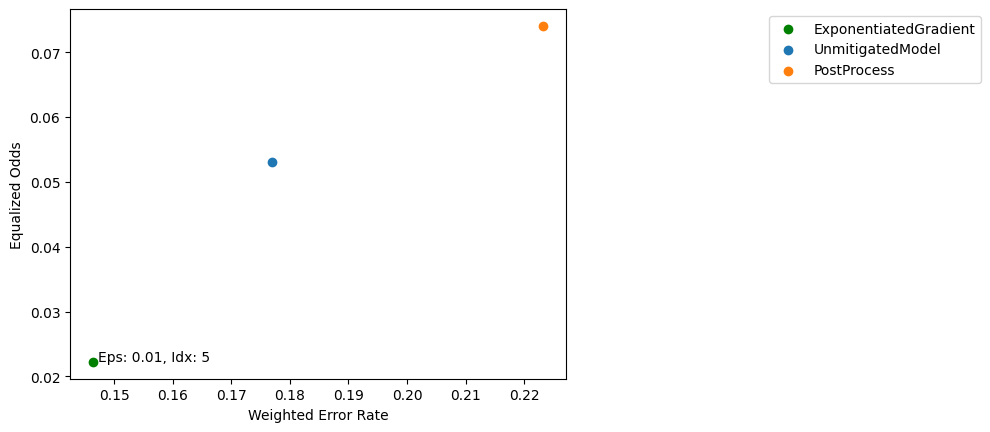

In [122]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))


In [123]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [124]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.01, Index number: 5.0


In [125]:
y_pred_inprocess = inprocess_model.predict(X_test)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)

In [126]:
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)


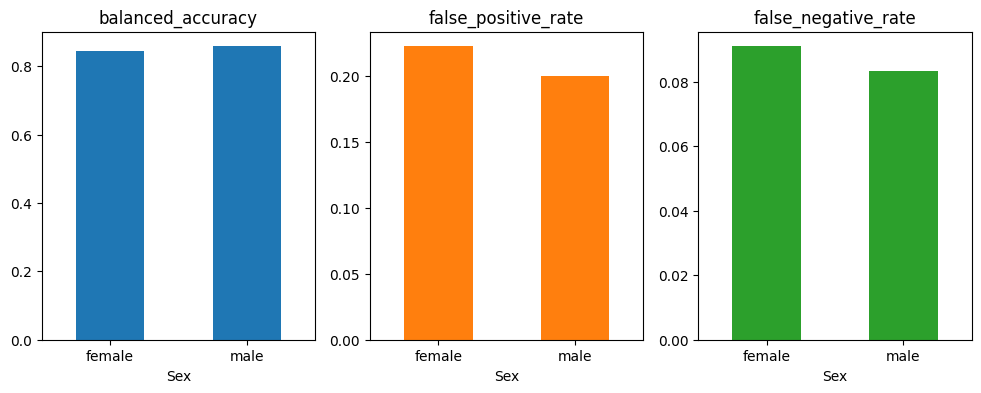

In [128]:
metricframe_inprocess.difference()[metrics_to_report]

metricframe_inprocess.overall[metrics_to_report]

metricframe_inprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)
plt.show()

### Discuss Performance and Trade-Offs

In [129]:
metric_error_pairs = [
    ("balanced_accuracy", "balanced_acc_error"),
    ("false_positive_rate", "false_positive_error"),
    ("false_negative_rate", "false_negative_error"),
]


def create_metricframe_w_errors(mframe, metrics_to_report, metric_error_pair):
    mframe_by_group = mframe.by_group.copy()
    for (metric_name, error_name) in metric_error_pair:
        mframe_by_group[metric_name] = mframe_by_group[metric_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[error_name] = mframe_by_group[error_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[metric_name] = mframe_by_group[metric_name].str.cat(
            mframe_by_group[error_name], sep="±"
        )
    return mframe_by_group[metrics_to_report]

In [130]:
create_metricframe_w_errors(
    metricframe_unmitigated, metrics_to_report, metric_error_pairs
)

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.823112
false_positive_rate    0.263889
false_negative_rate    0.089888
dtype: float64

In [131]:
create_metricframe_w_errors(
    metricframe_inprocess, metrics_to_report, metric_error_pairs
)

,balanced_accuracy,false_positive_rate,false_negative_rate
Sex,,,
female,0.843±0.082,0.222±0.111,0.091±0.120
male,0.858±0.047,0.200±0.083,0.083±0.043


In [132]:
metricframe_inprocess.overall[metrics_to_report]

create_metricframe_w_errors(
    metricframe_postprocess, metrics_to_report, metric_error_pairs
)

metricframe_postprocess.overall[metrics_to_report]

balanced_accuracy      0.776685
false_positive_rate    0.250000
false_negative_rate    0.196629
dtype: float64

## Model Card

In [73]:
print(model_card_imported)

False
